

# Project: Investigate TMDb movie data to predict movie success

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<img src="files/cover_image.png">
Image source: 
[kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata)

<a id='intro'></a>
## Introduction

> This data set contains information
about 10,000 movies collected from
The Movie Database (TMDb),
including user ratings and revenue.  This project is to explore the data and find the reasons for movie success, measured in  revenue.
> Here are the two questions that can be answered by investigating this dataset:
<br/> 1) Which genres are
most popular from
year to year? 
<br/> 2) What
kinds of properties
are associated with
movies that have high
revenues?

First, the data was loaded and data wrangling was performed to clean and trim the data for analysis;
<br> After data wrangling, explorative data analysis (EDA) was performed to answer the two questions above.  
1. Movies were put into three groups based on their release years, and the most popular movie genres were compared among the three groups to find out how the favorite genres changed from year to year.
2. To answer the second question, all movies were put into two groups based on their adjusted revenues.  Movies with revenues above the average was labeled as "success", and the rest of them labeded as "no_success".  Histograms of popularity, budget, runtime, and release year were comparied between "success" and "no_success" movies to find what make a movie successful.


In [103]:
# Import packages of pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> In this section the TMDb movie data was loaded as a dataframe *df* and some initial checks were performed to check for cleanliness, missing values.  

### General Properties of TMDb data

In [55]:
# Load TMDb data and print out a few lines.
df = pd.read_csv('tmdb-movies.csv')
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In [56]:
# Display information of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

From above results we can see the dataset has 10866 rows and 21 columns, with some missing values in a couple of columns.  The number of missing values is counted and displayed next.

In [57]:
# Count missing values in each column
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

According to the results above, some columns have a large number of missing values.  We can drop these columns that are not important in prodicting movie success, such as *homepage*, *taglines*...

### Deal with Missing Values and Duplicated Rows

In [58]:
# Drop these columns: 'homepage','director','overview','tagline','keywords','production_companies','cast','imdb_id'
index = ['homepage','director','overview','tagline','keywords','production_companies','cast','imdb_id']
df.drop(index, axis = 1, inplace = True)

In [59]:
# Comfirm the number of missing values in each column after dropping some columns in the previous cell
df.isnull().sum()

id                 0
popularity         0
budget             0
revenue            0
original_title     0
runtime            0
genres            23
release_date       0
vote_count         0
vote_average       0
release_year       0
budget_adj         0
revenue_adj        0
dtype: int64

Now, we only have 23 missing values in the *genres* column, which will be dropped next.

In [60]:
# Drop rows with missing values
df.dropna(inplace=True)

In [61]:
# Confirm that the number of missing values is zero for all columns
df.isnull().sum() 

id                0
popularity        0
budget            0
revenue           0
original_title    0
runtime           0
genres            0
release_date      0
vote_count        0
vote_average      0
release_year      0
budget_adj        0
revenue_adj       0
dtype: int64

OK, now the updated dataframe *df* does not have missing values, but there are lots of zeros in **budget** and **revenue**, as shown below

In [62]:
# Slice the datafram to keep only the rows with non-zero revenue and budget
df = df.query('budget !=0 and revenue != 0')

In [63]:
# Count the number of rows with non-zero revenue and budget
df.count()

id                3855
popularity        3855
budget            3855
revenue           3855
original_title    3855
runtime           3855
genres            3855
release_date      3855
vote_count        3855
vote_average      3855
release_year      3855
budget_adj        3855
revenue_adj       3855
dtype: int64

After slicing, we only have 3855 rows.  (original number of rows is 10866). Next we are going to find and drop duplicated rows 

In [64]:
# Check number of duplicated rows
df.duplicated().sum()

1

So, we have one duplicated row, which will be dropped in the next cell.

In [65]:
# Drop duplicated rows
df.drop_duplicates(inplace = True)

In [66]:
# Confirm there are no duplicates
df.duplicated().sum() == 0

True

In [67]:
# Check again the information of columns after data cleanning procedures above
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3854 entries, 0 to 10848
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3854 non-null   int64  
 1   popularity      3854 non-null   float64
 2   budget          3854 non-null   int64  
 3   revenue         3854 non-null   int64  
 4   original_title  3854 non-null   object 
 5   runtime         3854 non-null   int64  
 6   genres          3854 non-null   object 
 7   release_date    3854 non-null   object 
 8   vote_count      3854 non-null   int64  
 9   vote_average    3854 non-null   float64
 10  release_year    3854 non-null   int64  
 11  budget_adj      3854 non-null   float64
 12  revenue_adj     3854 non-null   float64
dtypes: float64(4), int64(6), object(3)
memory usage: 421.5+ KB


After data wrangling, the updated dataset has 3854 rows and 13 columns, the first few lines look like this:

In [68]:
# Show first few lines after data cleaning
df.head()

,id,popularity,budget,revenue,original_title,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,150000000,1513528810,Jurassic World,124,Action|Adventure|Science Fiction|Thriller,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,120,Action|Adventure|Science Fiction|Thriller,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,13.112507,110000000,295238201,Insurgent,119,Adventure|Science Fiction|Thriller,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,11.173104,200000000,2068178225,Star Wars: The Force Awakens,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,9.335014,190000000,1506249360,Furious 7,137,Action|Crime|Thriller,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


<a id='eda'></a>
## Exploratory Data Analysis


### Overall stastics of the data

In [69]:
# Show stastics of the dataset
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,3854.000000,3854.000000,3.854000e+03,3.854000e+03,3854.000000,3854.000000,3854.000000,3854.000000,3.854000e+03,3.854000e+03
mean,39888.185262,1.191554,3.720370e+07,1.076866e+08,109.220291,527.720291,6.168163,2001.261028,4.423999e+07,1.370647e+08
std,67222.527399,1.475162,4.220822e+07,1.765393e+08,19.922820,879.956821,0.794920,11.282575,4.480925e+07,2.161114e+08
min,5.000000,0.001117,1.000000e+00,2.000000e+00,15.000000,10.000000,2.200000,1960.000000,9.693980e-01,2.370705e+00
25%,6073.500000,0.462368,1.000000e+07,1.360003e+07,95.000000,71.000000,5.700000,1995.000000,1.309053e+07,1.835735e+07
50%,11321.500000,0.797511,2.400000e+07,4.480000e+07,106.000000,204.000000,6.200000,2004.000000,3.001611e+07,6.173068e+07
75%,38573.250000,1.368324,5.000000e+07,1.242125e+08,119.000000,580.000000,6.700000,2010.000000,6.061307e+07,1.632577e+08
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,338.000000,9767.000000,8.400000,2015.000000,4.250000e+08,2.827124e+09


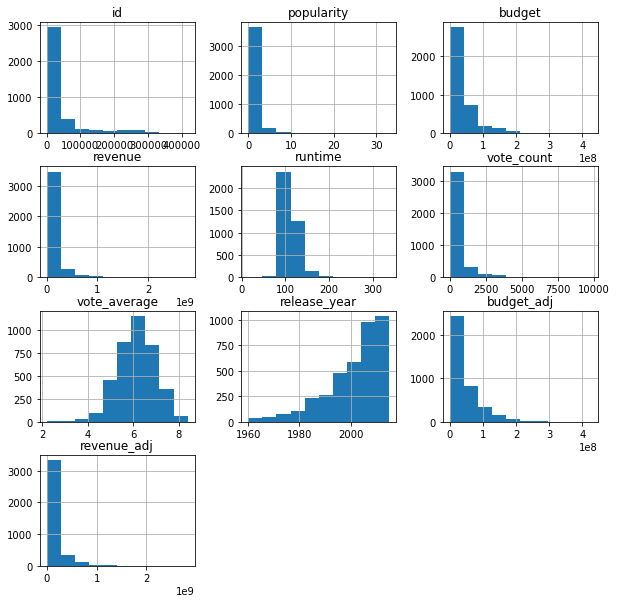

In [70]:
# quich check on the histograms of several columns
df.hist(figsize=(10,10));

1. From the statistical summary and histograms above, we can see the *popularity* skewed to the right with 1st quartile of 0.46 and 3rd quartile of 1.37, and an average of 1.19;
2. The distribution of *vote_average* is close to a normal distribution, with an average of 6.17, first and 3rd quartiles of 5.7 and 6.7;
3. The *release_year* is skewed to the left, and the histogram shows that half of movies were releasted after 2004.
4.  The adjusted revenue and budget (*budget_adj* and *revenue_adj* ) are skewed to the right.  The statistical table shows that the average adjusted revenue is 1.37e8 and the average adjusted budget is 4.42e7.

### Questions 1: Which genres are the most popular (with highest popularity values)?

<AxesSubplot:>

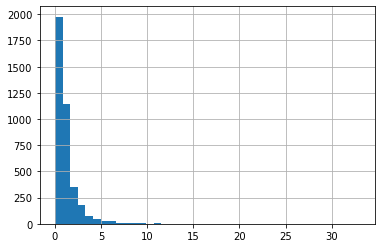

In [71]:
# Show histogram of the popularity column
df['popularity'].hist(bins=40)

From the statistics table above, we can see most of the popularity values are between 0 and 5, while there are a small number of very large values (>30).  
<br> Now, lets put the movies into three different groups based on their release year: movies from 1960-1979, from 1980-1999, and from 2000-2015:

In [72]:
df60_79 = df.query('release_year <1980') # movies from 1960-1979
df80_99 = df.query('release_year >= 1980 and release_year <1999') # movies from 1980-1999
df00_15 = df.query('release_year >= 2000') # movies from 2000-2015

In [73]:
# Sort the dataframe by popularity, by default, this is in asending order
df60_79.sort_values(by=['popularity'], inplace=True)
df80_99.sort_values(by=['popularity'], inplace=True)
df00_15.sort_values(by=['popularity'], inplace=True)

/Users/mingmin/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mingmin/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mingmin/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [74]:
# Display the 5 most popular movies in 1960-1979 movies
df60_79[['genres','popularity']].tail(5)

,genres,popularity
9758,Drama|Crime,3.264571
9719,Science Fiction|Mystery|Adventure,3.309196
7825,Horror|Action|Thriller|Science Fiction,4.935897
7269,Drama|Crime,5.738034
1329,Adventure|Action|Science Fiction,12.037933


In [75]:
# Display the 5 most popular movies in 1980-1999 movies
df80_99[['genres','popularity']].tail(5)

,genres,popularity
7309,Adventure|Action|Science Fiction,5.488441
6081,Adventure|Comedy|Science Fiction|Family,6.095293
4179,Comedy|Drama|Romance,6.715966
4178,Drama|Crime,7.192039
4177,Thriller|Crime,8.093754


In [76]:
# Display the 5 most popular movies in 2000-2015 movies
df00_15[['genres','popularity']].tail(5)

,genres,popularity
2,Adventure|Science Fiction|Thriller,13.112507
630,Action|Science Fiction|Adventure,14.311205
629,Adventure|Drama|Science Fiction,24.949134
1,Action|Adventure|Science Fiction|Thriller,28.419936
0,Action|Adventure|Science Fiction|Thriller,32.985763


The tables above show that the most popular movie genres changed over time. The most popular genres are **Adventure|Action|Science Fiction** for movies in 1960-1979, **Thriller|Crime** for movies in 1980-1999, and **Action|Adventure|Science Fiction|Thriller** for movies in 2000-2015.

### Question 2: What kinds of properties are associated with movies that have high revenues?
In this section, we are going to explore factors that could influence the revenues of movies.  The column **revenue_adj** will be used as the dependent variable, and four independent variables (**popularity, budget_adj, runtime, and release_year**) will be investigated to evaluate their influence on the **revenue_adj**

Movies with **revenue_adj** larger than the average adjusted revenue will be labeled **"success"**, and movies with **revenue_adj** smaller than the average adjusted revenue will be labeled **"no success"**

In [78]:
# Get the average adjusted revenue (not considering zero values)
avg_revenue = np.mean(df.query('revenue_adj != 0').revenue_adj)
avg_revenue

137064690.30304137

So the average of the non-zero **revenue_adj** is about 1.37e8.  We can now define "success" and "no success" movies using this average revenue_adj.

#### Divide the movies into two groups: "success" and "no_success"


In [79]:
# Define success and no_success dataframes 
success = df.query('revenue_adj >= {}'.format(avg_revenue)) # revenue_adj >  average
no_success = df.query('revenue_adj !=0 and revenue_adj < {}'.format(avg_revenue)) # revenue_adj <  average

In [80]:
# number of success and no_success movies
success.revenue_adj.count(), no_success.revenue_adj.count()

(1121, 2733)

So we have 1121 "success" movies with high revenues, and 2733 "no_success" movies with low revenues.  Explorative data analysis (EDA) will be performed to see what make a "success" movie successful. Four factors are considered: *popularity*, *budget_adj*, *release_year*, and *runtime*
#### (1) popularity values
One might think that a popular movie is more likely to be a success and get a high revenue, let's check if this is true

Text(0, 0.5, 'Number of movies')

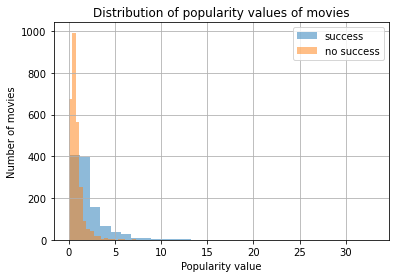

In [81]:
# Compare histograms of "success" and "no_success" movies 
success.popularity.hist(alpha = 0.5, bins = 30, label = 'success')
no_success.popularity.hist(alpha = 0.5, bins = 30, label = 'no success')
plt.legend()
plt.title('Distribution of popularity values of movies')
plt.xlabel('Popularity value')
plt.ylabel('Number of movies')

The histogram above shows that "success" movies have higher popularity distribution than "no_success" movies, which can be further confirmed by the bar plot of the average popularity in the two groups beloe. So it is  consistent with the hypothesis that more popular movies are more successful.

Text(0.5, 1.0, 'Popularity comparison')

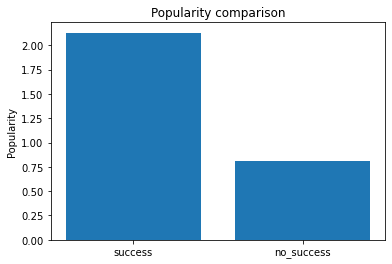

In [82]:
# Make the bar plot of the average popularity of the "success" and "no_success" movies for comparison
plt.bar(['success', 'no_success'],[success.popularity.mean(), no_success.popularity.mean()])
plt.ylabel('Popularity')
plt.title('Popularity comparison')

#### (2) adjusted budget
Let's see if the amount of money spent in producing a movie plays a role in its success ...

Text(0, 0.5, 'Number of movies')

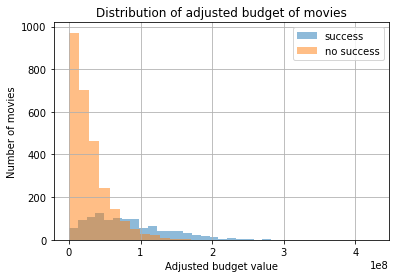

In [83]:
# Compare histograms of "success" and "no_success" movies 
success.budget_adj.hist(alpha = 0.5, bins = 30, label = 'success')
no_success.budget_adj.hist(alpha = 0.5, bins = 30, label = 'no success')
plt.legend()
plt.title('Distribution of adjusted budget of movies')
plt.xlabel('Adjusted budget value')
plt.ylabel('Number of movies')

Text(0.5, 1.0, 'Budget comparison')

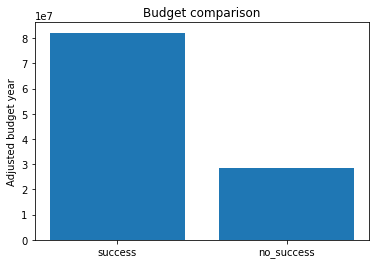

In [84]:
# Make the bar plot of the average budget of the "success" and "no_success" movies for comparison
plt.bar(['success', 'no_success'],[success.budget_adj.mean(), no_success.budget_adj.mean()])
plt.ylabel('Adjusted budget year')
plt.title('Budget comparison')

The histograms and the bar plot of adjusted budget above show that "success" movies have a higher adjusted budget value than "no_success" movies.  So it is true that movies made with more money can make more money.

#### (3) release year
Next, let's see if the release year affect the movies' success. Could people love movies more in the past then they do today?

Text(0, 0.5, 'Number of movies')

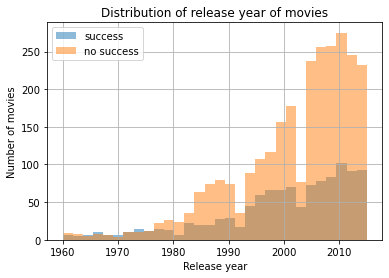

In [85]:
# Compare histograms of "success" and "no_success" movies 
success.release_year.hist(alpha = 0.5, bins = 30, label = 'success')
no_success.release_year.hist(alpha = 0.5, bins = 30, label = 'no success')
plt.legend()
plt.title('Distribution of release year of movies')
plt.xlabel('Release year')
plt.ylabel('Number of movies')

Text(0.5, 1.0, 'Release year comparison')

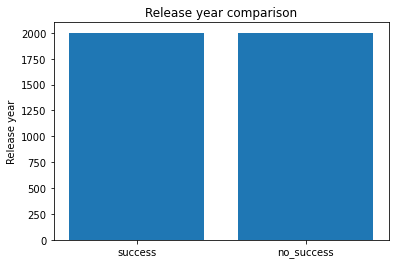

In [86]:
# Make the bar plot of the average release year of the "success" and "no_success" movies for comparison
plt.bar(['success', 'no_success'],[success.release_year.mean(), no_success.release_year.mean()])
plt.ylabel('Release year')
plt.title('Release year comparison')

The histograms show no obvious difference in the distributions of release year of "success" and "no_success" movies.  This is consistent with the bar plot.  So the release year really dose not matter very much, and it seems that people today love movies the same  as they did in the past.
<br> Next, we are going to explore how the revenues change over the years for both "success" and "no_success" movies by scatter plots.

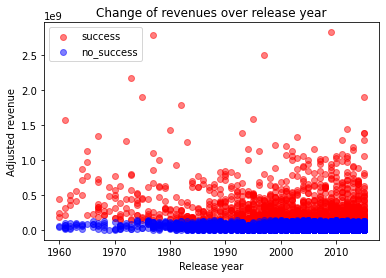

In [100]:
# scatter plot for the adjusted revenue versus release year
plt.scatter(success.release_year, success.revenue_adj, alpha=0.5, color='red', label = 'success')
plt.scatter(no_success.release_year,no_success.revenue_adj, alpha = 0.5, color='blue', label = 'no_success')
plt.xlabel('Release year')
plt.ylabel('Adjusted revenue')
plt.title('Change of revenues over release year')
plt.legend()

The scatter plot above shows that the revenues did not change a lot over the years.  The "success" movies show larger variations in the revenues than the "no_success" movies 
#### (4) runtime
Could runtime affect a movie's revenue?  Is it possible that short movies are more likely to make more money?

Text(0, 0.5, 'Number of movies')

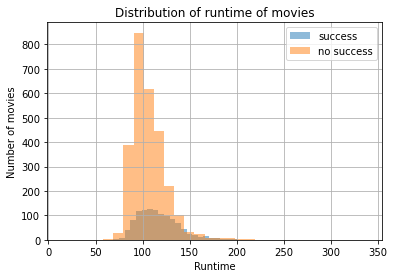

In [87]:
# Compare histograms of "success" and "no_success" movies 
success.runtime.hist(alpha = 0.5, bins = 30, label = 'success')
no_success.runtime.hist(alpha = 0.5, bins = 30, label = 'no success')
plt.legend()
plt.title('Distribution of runtime of movies')
plt.xlabel('Runtime')
plt.ylabel('Number of movies')

Text(0.5, 1.0, 'Runtime comparison')

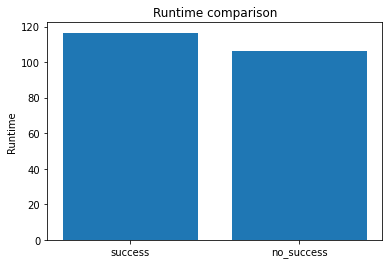

In [88]:
# Make the bar plot of the average runtime of the "success" and "no_success" movies for comparison
plt.bar(['success', 'no_success'],[success.runtime.mean(), no_success.runtime.mean()])
plt.ylabel('Runtime')
plt.title('Runtime comparison')

So it seems that the run time doesn't affect the revenue much, either, as the distributions of both "success" and "no_success" movies are almost the same. The bar plot shows the "success" movies have a slightly longer runtime, but it is hard to say if runtime has a significant effect on movie success.

<a id='conclusions'></a>
## Conclusions

> **Summary:** The TMDb movie data was loaded, cleaned, and trimed in preparation for Explorative Data Analysis to find out what make a success movie successful.  After data wrangling, the dataset has 10842 rows and 13 columns.  
> 1. The 5 most popular movie genres were displayed for movies in different time periods (1960-1979, 1980-1999, and 2000-2015).  The most popular genres are Adventure|Action|Science Fiction for movies in 1960-1979, Thriller|Crime for movies in 1980-1999, and Action|Adventure|Science Fiction|Thriller for movies in 2000-2015.
> 2. Four different factors that could affect the movie revenues were examined to answer the second question: what kinds of properties make a movie successful? It was found that movies with higher budgets or movies with higher popularity are more successful and made more revenues, while the release year and runtime do not play an important in role in movies' success.

> **Limitations**
> 1. In the data wrangling section, columns and rows with missing values were directly dropped.  Further inspection should be done to make more use of the data that were otherwise dropped.
> 2. In the EDA section, only histogram and bar plot were used for data visualization and analysis.  Other plots such as scatter and pie chart could be used to gain more insights of the data.